# Introduction to Machine Learning: Final Project 
<b>Name:</b> Tammy Zhang

<b>NetID:</b> tz332

### Background
The annual flowering of Japanese cherry trees (<i>Prunus jamasakura</i>) at the end of March is a major tourist event in many cities around the world. However, over time, the peak flowering dates of these trees have begun to shift significantly earlier in a pattern that scientists have argued is due to overall warmer temperatures on average from climate change. These changes have been so pronounced that in some places such as Washington D.C., traditional cherry blossom festivals now completely miss the peak flowering date altogether. This has significant economic implications for regions that may rely on touristry as a major source of local income.

In Kyoto, Japan, records of the peak flowering date have been kept since 800 A.D. and compiled into a dataset. Last year's March saw some of the warmest temperatures on record, and notably, the 2021 flowering date was the earliest one in 1200 years.

Source: https://www.bbc.com/news/world-asia-56574142 

### Problem Statement

Are the peak flowering dates of <i>Prunus jamasakura</i> in Kyoto, Japan associated with increases in March temperature? 
* Does a warmer March correlate with an earlier flowering date?
* i.e. can March temperatures be used to predict flowering date with any considerable accuracy?
* Are there other weather factors (precipitation, sunlight, etc) that may play a part, and do any of them have a greater correlation with flowering date than average March temperature?

Hypothesis: Earlier peak flowering dates will be associated with higher March temperatures in Kyoto to some extent, but predictions based solely on temperature alone will be somewhat unreliable.

## Part 1: Can Average March Temperature Predict Flowering Date?

<b>About the data:</b> Taken from http://atmenv.envi.osakafu-u.ac.jp/aono/kyophenotemp4/. There are two main datasets used in this section: one containing average March temperatures for Kyoto and the other containing the full-flowering date of Kyoto cherry trees (expressed as an integer representing days elapsed since January 1st of that year).

### Data Cleaning and Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
    
dates = pd.read_csv('KyotoFlowerData.csv')
temps = pd.read_csv('KyotoTempData.csv')

In [2]:
# Cleaning the temps dataset
# If observed temp not available, use reconstructed instead
temps = temps.replace(-999.9, np.nan)
temps[" Observed Temp"].fillna(temps["Reconstructed Temp"], inplace=True)
temps = temps.drop(["Reconstructed Temp"], axis = 1)
temps = temps.rename(columns={" Observed Temp": "Temp"})

In [3]:
# Cleaning the dates dataset
dates = dates.drop(['AD','Full-flowering date','Source code','Data type code','Reference Name'], axis = 1)

# Combine dataframes into one called "data" and drop all rows containing NaN
data = pd.concat([temps, dates], axis=1)
data = data.dropna()
data.head()

,AD,Temp,Full-flowering date (DOY)
11,812,9.9,92.0
14,815,6.0,105.0
30,831,8.6,96.0
50,851,5.2,108.0
52,853,6.3,104.0


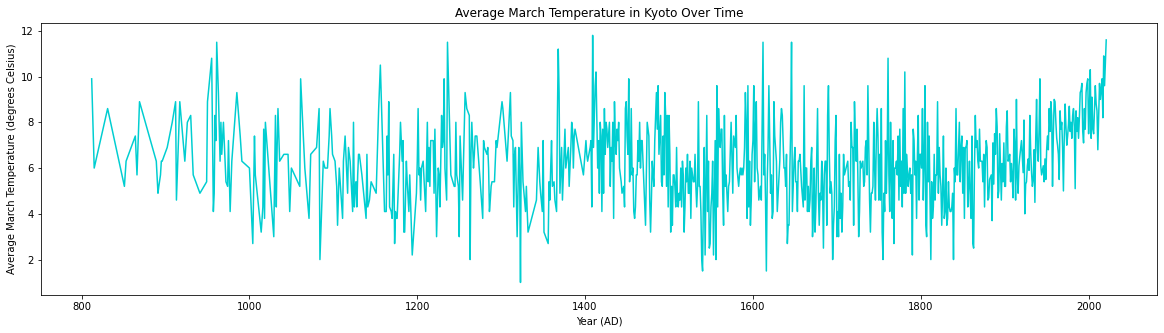

In [4]:
plt.figure(figsize=(20,5))
plt.plot(data["AD"], data["Temp"], color='darkturquoise')
plt.title('Average March Temperature in Kyoto Over Time')
plt.xlabel('Year (AD)')
plt.ylabel('Average March Temperature (degrees Celsius)')
plt.show()

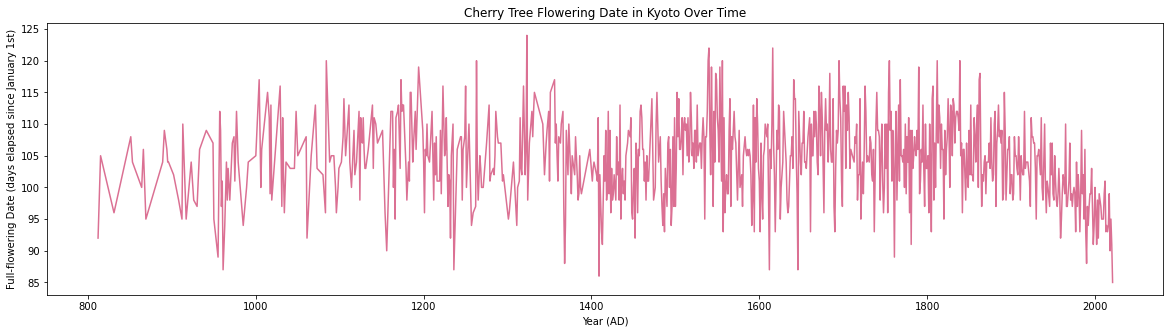

In [5]:
plt.figure(figsize=(20,5))
plt.plot(data["AD"], data["Full-flowering date (DOY)"], color='palevioletred')
plt.title('Cherry Tree Flowering Date in Kyoto Over Time')
plt.xlabel('Year (AD)')
plt.ylabel('Full-flowering Date (days elapsed since January 1st)')
plt.show()

Just from plotting these two variables, it appears that average March temperature and cherry tree flowering date have a strong inverse relationship. Of note is the gradual increase of average March temperature after the 1800s and the corresponding decrease in flowering date, indicating earlier blooms over time in the last two centuries.

### Creating a Model (Linear Regression)

In [6]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

features = data[['Temp']]
target = data['Full-flowering date (DOY)']
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)
model = LinearRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test) 
print("Score:", model.score(x_test, y_test))

Score: 0.9754451578044566


In [7]:
# Assessing model accuracy with a baseline
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test, predictions)
target_mean = target.mean()
baseline = np.full((len(predictions),), target_mean)
baseline_MSE = mean_squared_error(baseline, predictions)

score = 1 - MSE / baseline_MSE 
print("Score: ", score)

Score:  0.9749828649997582


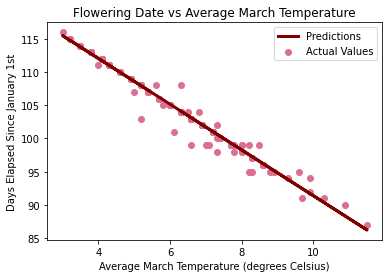

In [8]:
plt.scatter(x_test, y_test, color='palevioletred')
plt.plot(x_test, predictions,'k', color='maroon', linewidth=3)
plt.legend(["Predictions","Actual Values"])
plt.title('Flowering Date vs Average March Temperature')
plt.xlabel('Average March Temperature (degrees Celsius)')
plt.ylabel('Days Elapsed Since January 1st')
plt.show()

Surprisingly, this linear regression model seems to indicate an extremely high correlation between temperature and flowering date. The slope of the trendline suggests that increased March temperatures are associated with earlier flowering dates; for reference, the 85th day of the year is March 26 while the 115th day of the year is April 25. This seems to suggest that a difference of about 15 degrees Celsius can correlate with a month's difference of flowering date!

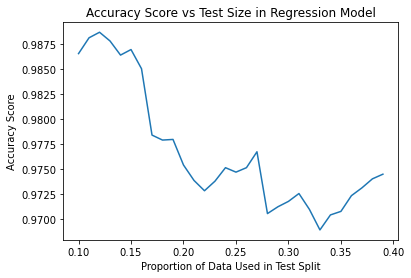

Maximum score is 0.988717174734073  at a test split of 0.12


In [9]:
# Investigating how test split can change the model accuracy
x_values = []
y_values = []
for i in range(10, 40):
    test_size_var = i / 100
    x_values.append(test_size_var)
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=test_size_var, random_state=42)
    model = LinearRegression()
    model.fit(x_train, y_train)
    y_values.append(model.score(x_test, y_test))
plt.plot(x_values, y_values)
plt.title('Accuracy Score vs Test Size in Regression Model')
plt.xlabel('Proportion of Data Used in Test Split')
plt.ylabel('Accuracy Score')
plt.show()

maximum = max(y_values)
max_index = y_values.index(maximum)
print("Maximum score is", maximum, " at a test split of", x_values[max_index])

## Part 2: Other Influential Weather Factors

### Data Cleaning and Preparation

Now we will look at weather factors other than average temperature to determine if any of them have comparable influence on flowering date, or if temperature is still the strongest predictor. 

<b>About the data:</b> taken from https://www.data.jma.go.jp/obd/stats/etrn/view/monthly_s3_en.php?block_no=47759&view=1. All data represents monthly averages - we will continue to look at March statistics.

In [10]:
# Extract March weather data from other datasets

# Weather datasets differ in what years they have available.
# Year is cast to a float in all sets so the data is merged in a way that aligns with the year column properly.
# Otherwise, year is automatically cast to float in one dataset but not the other (due to NaN being a float)
# and the datasets are not merged correctly.

data = data.rename(columns={"AD": "Year"})
data["Year"] = data['Year'].astype(float)

cloud_cover = pd.read_csv("KyotoCloud.csv", usecols=["Year", "Mar"])
cloud_cover = cloud_cover.rename(columns={"Mar": "Cloud Cover"})
cloud_cover["Year"] = cloud_cover['Year'].astype(float)

humidity = pd.read_csv("KyotoHumidity.csv", usecols=["Year", "Mar"])
humidity = humidity.rename(columns={"Mar": "Humidity"})
humidity["Year"] = humidity['Year'].astype(float)

precip = pd.read_csv("KyotoPrecip.csv", usecols=["Year", "Mar"])
precip = precip.rename(columns={"Mar": "Precipitation"})
precip["Year"] = precip['Year'].astype(float)

sun = pd.read_csv("KyotoSun.csv", usecols=["Year", "Mar"])
sun = sun.rename(columns={"Mar": "Sunshine Duration"})
sun["Year"] = sun['Year'].astype(float)

# Using fillna temporarily to not lose rows while merging
weather_data = pd.merge(data, cloud_cover, on=["Year"], how='left').fillna(-999.9)
weather_data = pd.merge(weather_data, humidity, on=["Year"], how='left').fillna(-999.9)
weather_data = pd.merge(weather_data, precip, on=["Year"], how='left').fillna(-999.9)
weather_data = pd.merge(weather_data, sun, on=["Year"], how='left').fillna(-999.9)

weather_data = weather_data.replace(-999.9, np.nan)
weather_data = weather_data.dropna()
weather_data["Year"] = weather_data["Year"].astype(int)

weather_data = weather_data.dropna(axis = 0, thresh = 2)

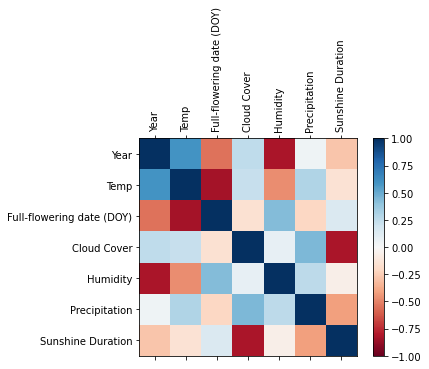

In [11]:
# Getting a correlation matrix to determine which variable to analyze
corr = weather_data.corr()

fig = plt.figure()
ax = fig.add_subplot(111) 
fig.colorbar(ax.matshow(corr, cmap='RdBu', vmin=-1, vmax=1)) 

ax.set_xticks(range(len(corr.columns))) 
ax.set_xticklabels(corr.columns)
for tick in ax.get_xticklabels(): 
        tick.set_rotation(90)

ax.set_yticks(range(len(corr.columns))) 
ax.set_yticklabels(corr.columns)

plt.show()

From this correlation matrix, we can determine that the factor most closely correlated with flowering date is by far temperature. This aligns with the results of the linear regression model from earlier, but it is interesting to see that other weather factors don't seem to have influence on anywhere close to the same level as temperature.

Out of curiosity, we can see how a model built with factors other than temperature will perform.

In [12]:
factors = ["Humidity"]
features = weather_data[factors]
target = weather_data['Full-flowering date (DOY)']
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test) 
print("Score:", model.score(x_test, y_test))

Score: 0.10257260862377615


The resulting score is very low, suggesting that even the next most correlated variable - humidity - is nowhere as strong of a predictor as temperature.

In [13]:
factors = ["Humidity", "Precipitation"]
features = weather_data[factors]
target = weather_data['Full-flowering date (DOY)']
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test) 
print("Score:", model.score(x_test, y_test))

Score: -0.01979639889589957


This is true when also considering precipitation...

In [14]:
factors = ["Humidity", "Precipitation", "Cloud Cover", "Sunshine Duration"]
features = weather_data[factors]
target = weather_data['Full-flowering date (DOY)']
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test) 
print("Score:", model.score(x_test, y_test))

Score: -0.025661064259218325


...and when taking cloud cover and sunshine duration into account.

## Conclusions


Overall, I was very surprised by the results of this investigation. Looking back at my hypothesis and predictions - that temperature would have some correlation with flowering dates, but not a substantial amount, I was not expecting temperature to have as strong of an association as it did. Considering how closely plant growth is tied to sunlight and precipitation, I didn't think that temperature would have as strong of a relationship - but in the end, these other factors barely had any relation at all.

In the end, this data has some interesting applications considering climate change in the future. It could sound insubstantial to say that cherry trees bloom earlier because of warmer weather, but considered alongside a growing body of research providing evidence for climate change, the significance of looking at this kind of data becomes more apparent. There are also important implications for towns and cities that derive large parts of their economy from annual cherry tree festivals, which can draw large numbers of tourists. Considering how in some places the timing of the festival has remained unchanged for decades and has slowly become outdated as a result, this could be a vital concept for event organizers to keep in mind for the future.

For future improvements to this project, I'm interested in seeing how analyzing this data from a time series perspective would work out. It would be nice to observe if it is possible to predict the flowering date of coming years by predicting future March temperatures - the analysis of this can become rather complicated, but there are packages out there that can specifically look into circular data like temperatures throughout a year and build predictions. Furthermore, I would likely search for more cherry tree data from other places - normalizing this could be a challenge, but it would be valuable to have much more data points than represented here.